## Installation

NOTE: The installs will take 15-20 minutes. A GPU runtime is required. The runtime will probably have to restart once or twice during the process.

In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:33
🔁 Restarting kernel...


In [2]:
import time
time.sleep(7)

In [1]:
import condacolab
condacolab.check()

✨🍰✨ Everything looks OK!


In [2]:
%%bash
conda update -n base conda
conda install --channel conda-forge featuretools --yes
conda install -c rapidsai -c nvidia -c conda-forge dask-ml rapids=21.10 python=3.7 cudatoolkit=11.2 --yes

Solving environment: ...working... done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - conda


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    brotlipy-0.7.0             |py37h5e8e339_1003         342 KB  conda-forge
    c-ares-1.18.1              |       h7f98852_0         113 KB  conda-forge
    ca-certificates-2021.10.8  |       ha878542_0         139 KB  conda-forge
    certifi-2021.10.8          |   py37h89c1867_1         145 KB  conda-forge
    cffi-1.15.0                |   py37h036bc23_0         225 KB  conda-forge
    chardet-4.0.0              |   py37h89c1867_2         199 KB  conda-forge
    charset-normalizer-2.0.0   |     pyhd8ed1ab_0          32 KB  conda-forge
    colorama-0.4.4             |     pyh9f0ad1d_0          18 KB  conda-forge
    conda-4.10.3               |   py37h89c1867_3         3.1 MB  conda-forge
    conda-package-

WARNING conda.core.solve:_add_specs(611): pinned spec cudatoolkit=11.1 conflicts with explicit specs.  Overriding pinned spec.
WARNING conda.core.solve:_add_specs(611): pinned spec cudatoolkit=11.1 conflicts with explicit specs.  Overriding pinned spec.
WARNING conda.core.solve:_add_specs(611): pinned spec cudatoolkit=11.1 conflicts with explicit specs.  Overriding pinned spec.


# Dask

## Example: ML

In [3]:
from dask.distributed import Client, progress
client = Client(processes=False, threads_per_worker=4,
                n_workers=1, memory_limit='2GB')
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://172.28.0.2:8787/status,
Dashboard: http://172.28.0.2:8787/status,Workers: 1
Total threads: 4,Total memory: 1.86 GiB
Status: running,Using processes: False
Comm: inproc://172.28.0.2/211/1,Workers: 1
Dashboard: http://172.28.0.2:8787/status,Total threads: 4
Started: Just now,Total memory: 1.86 GiB
Comm: inproc://172.28.0.2/211/4,Total threads: 4
Dashboard: http://172.28.0.2:40565/status,Memory: 1.86 GiB
Nanny: None,


### Create Scikit-Learn Estimator

In [4]:
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import pandas as pd

We'll use scikit-learn to create a pair of small random arrays, one for the features `X`, and one for the target `y`.

In [5]:
X, y = make_classification(n_samples=1000, random_state=0)
X[:5]

array([[-1.06377997,  0.67640868,  1.06935647, -0.21758002,  0.46021477,
        -0.39916689, -0.07918751,  1.20938491, -0.78531472, -0.17218611,
        -1.08535744, -0.99311895,  0.30693511,  0.06405769, -1.0542328 ,
        -0.52749607, -0.0741832 , -0.35562842,  1.05721416, -0.90259159],
       [ 0.0708476 , -1.69528125,  2.44944917, -0.5304942 , -0.93296221,
         2.86520354,  2.43572851, -1.61850016,  1.30071691,  0.34840246,
         0.54493439,  0.22532411,  0.60556322, -0.19210097, -0.06802699,
         0.9716812 , -1.79204799,  0.01708348, -0.37566904, -0.62323644],
       [ 0.94028404, -0.49214582,  0.67795602, -0.22775445,  1.40175261,
         1.23165333, -0.77746425,  0.01561602,  1.33171299,  1.08477266,
        -0.97805157, -0.05012039,  0.94838552, -0.17342825, -0.47767184,
         0.76089649,  1.00115812, -0.06946407,  1.35904607, -1.18958963],
       [-0.29951677,  0.75988955,  0.18280267, -1.55023271,  0.33821802,
         0.36324148, -2.10052547, -0.4380675 , -

We'll fit a [Support Vector Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html), using [grid search](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) to find the best value of the $C$ hyperparameter.

In [6]:
param_grid = {"C": [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
              "kernel": ['rbf', 'poly', 'sigmoid'],
              "shrinking": [True, False]}

grid_search = GridSearchCV(SVC(gamma='auto', random_state=0, probability=True),
                           param_grid=param_grid,
                           return_train_score=False,
                           cv=3,
                           n_jobs=-1)

To fit that normally, we would call

```python
grid_search.fit(X, y)
```

To fit it using the cluster, we just need to use a context manager provided by joblib.

In [7]:
import joblib

with joblib.parallel_backend('dask'):
    grid_search.fit(X, y)

We fit 48 different models, one for each hyper-parameter combination in `param_grid`, distributed across the cluster. At this point, we have a regular scikit-learn model, which can be used for prediction, scoring, etc.

In [8]:
pd.DataFrame(grid_search.cv_results_).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,param_shrinking,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.414208,0.037573,0.054960,0.016861,0.001,rbf,True,"{'C': 0.001, 'kernel': 'rbf', 'shrinking': True}",0.502994,0.501502,0.501502,0.501999,0.000704,41
1,0.474693,0.044649,0.054291,0.000614,0.001,rbf,False,"{'C': 0.001, 'kernel': 'rbf', 'shrinking': False}",0.502994,0.501502,0.501502,0.501999,0.000704,41
2,0.347080,0.033178,0.034006,0.007240,0.001,poly,True,"{'C': 0.001, 'kernel': 'poly', 'shrinking': True}",0.502994,0.501502,0.501502,0.501999,0.000704,41
3,0.328874,0.020372,0.035878,0.010219,0.001,poly,False,"{'C': 0.001, 'kernel': 'poly', 'shrinking': Fa...",0.502994,0.501502,0.501502,0.501999,0.000704,41
4,0.505472,0.014673,0.054025,0.006594,0.001,sigmoid,True,"{'C': 0.001, 'kernel': 'sigmoid', 'shrinking':...",0.502994,0.501502,0.501502,0.501999,0.000704,41


In [9]:
grid_search.predict(X)[:5]

array([0, 1, 1, 1, 0])

In [10]:
grid_search.score(X, y)

0.983

For more on training scikit-learn models with distributed joblib, see the [dask-ml documentation](http://dask-ml.readthedocs.io/en/latest/joblib.html).

### Training on Large Datasets

Most estimators in scikit-learn are designed to work on in-memory arrays. Training with larger datasets may require different algorithms.

All of the algorithms implemented in Dask-ML work well on larger than memory datasets, which you might store in a [dask array](http://dask.pydata.org/en/latest/array.html) or [dataframe](http://dask.pydata.org/en/latest/dataframe.html).

In [11]:
%matplotlib inline

In [12]:
import dask_ml.datasets
import dask_ml.cluster
import matplotlib.pyplot as plt

In this example, we'll use `dask_ml.datasets.make_blobs` to generate some random *dask* arrays.

In [13]:
X, y = dask_ml.datasets.make_blobs(n_samples=10000000,
                                   chunks=1000000,
                                   random_state=0,
                                   centers=3)
X = X.persist()
X

dask.array<concatenate, shape=(10000000, 2), dtype=float64, chunksize=(1000000, 2), chunktype=numpy.ndarray>

We'll use the k-means implemented in Dask-ML to cluster the points. It uses the `k-means||` (read: "k-means parallel") initialization algorithm, which scales better than `k-means++`. All of the computation, both during and after initialization, can be done in parallel.

In [14]:
km = dask_ml.cluster.KMeans(n_clusters=3, init_max_iter=2, oversampling_factor=10)
km.fit(X)

KMeans(init_max_iter=2, n_clusters=3, oversampling_factor=10)

We'll plot a sample of points, colored by the cluster each falls into.

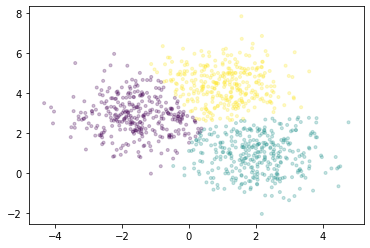

In [15]:
fig, ax = plt.subplots()
ax.scatter(X[::10000, 0], X[::10000, 1], marker='.', c=km.labels_[::10000],
           cmap='viridis', alpha=0.25);

For all the estimators implemented in Dask-ML, see the [API documentation](http://dask-ml.readthedocs.io/en/latest/modules/api.html).

# RAPIDS

## Example: Using cuSpatial to Correlate Taxi Data after a Format Change
In 2017, the NYC Taxi data switched from giving their pickup and drop off locations in `lat/lon` to one of 262 `LocationID`s.  While these `LocationID`s made it easier to determine some regions and borough information that was lacking in the previous datasets, it made it difficult to compare datasets before and after this transition.  



By using cuSpatial `Points in Polygon` (PIP), we can quickly and easily map the latitude and longitude of the pre-2017 taxi dataset to the `LocationID`s of the 2017+ dataset.  In this notebook, we will show you how to do so.  cuSpatial 0.14 PIP only works on 31 polygons per call, so we will show how to process this larger 263 polygon shapefile with minimal memory impact.  cuSpatial 0.15 will eliminate the 31 polygon limitation and provide substantial additional speedup.

You may need a 16GB card or larger.

### Imports

In [16]:
import cuspatial
import geopandas as gpd
import cudf
from numba import cuda
import numpy as np

### Download the Data
We're going to download the January NYC Taxi datasets for 2016 and 2017.  We also need the NYC Taxi Zones 

In [17]:
!if [ ! -f "tzones_lonlat.json" ]; then curl "https://data.cityofnewyork.us/api/geospatial/d3c5-ddgc?method=export&format=GeoJSON" -o tzones_lonlat.json; else echo "tzones_lonlat.json found"; fi
!if [ ! -f "taxi2016.csv" ]; then curl https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2016-01.csv -o taxi2016.csv; else echo "taxi2016.csv found"; fi   
!if [ ! -f "taxi2017.csv" ]; then curl https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2017-01.csv -o taxi2017.csv; else echo "taxi2017.csv found"; fi

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3801k    0 3801k    0     0   882k      0 --:--:--  0:00:04 --:--:--  882k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1629M  100 1629M    0     0  13.5M      0  0:02:00  0:02:00 --:--:-- 16.5M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  815M  100  815M    0     0  15.3M      0  0:00:52  0:00:52 --:--:-- 16.4M


### Read in the Taxi Data with cuDF
Let's read in the pickups and dropoffs for 2016 and 2017.

In [18]:
taxi2016 = cudf.read_csv("taxi2016.csv")
taxi2017 = cudf.read_csv("taxi2017.csv")

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 1.42 GiB -- Worker memory limit: 1.86 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 1.42 GiB -- Worker memory limit: 1.86 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 1.42 GiB -- Worker memory limit: 1.86 GiB
distributed.worker - WARNING - Worker is at 89% memory usage. Pausing worker.  Process memory: 1.67 GiB -- Worker memory limit: 1.86 GiB
distr

Let's have a look at the columns in `taxi2016` and `taxi2017` to verify the difference.

In [19]:
set(taxi2017.columns).difference(set(taxi2016.columns))

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 1.43 GiB -- Worker memory limit: 1.86 GiB


{'DOLocationID', 'PULocationID'}

### Read in the Spatial Data with cuSpatial

cuSpatial loads polygons into a `cudf.Series` of _Feature offsets_, a `cudf.Series` of _ring offsets_, and a `cudf.DataFrame` of `x` and `y` coordinates (which can be used for lon/lat as in this case) with the `read_polygon_shapefile` function. We're working on more advanced I/O integrations and nested `Columns` this year.

In [20]:
tzones = gpd.GeoDataFrame.from_file('tzones_lonlat.json')
tzones.to_file('cu_taxi_zones.shp')

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 1.44 GiB -- Worker memory limit: 1.86 GiB
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 1.44 GiB -- Worker memory limit: 1.86 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 1.44 GiB -- Worke

In [21]:
taxi_zones = cuspatial.read_polygon_shapefile('cu_taxi_zones.shp')

### Converting lon/lat coordinates to LocationIDs with cuSpatial
Looking at the taxi zones and the taxi2016 data, you can see that
- 10.09 million pickup locations
- 10.09 million dropoff locations
- 263 LocationID features
- 354 LocationID rings
- 98,192 LocationID coordinates

Now that we've collected the set of pickup locations and dropoff locations, we can use `cuspatial.point_in_polygon` to quickly determine which pickups and dropoffs occur in each borough.

To do this in a memory efficient way, instead of creating two massive 10.09 million x 263 arrays, we're going to use the 31 polygon limit to our advantage and map the resulting true values in the array a new `PULocationID` and `DOLocationID`, matching the 2017 schema.  Locations outside of the `LocationID` areas are `264` and `265`.  We'll be using 264 to indicate our out-of-bounds zones.

In [22]:
pip_iterations = list(np.arange(0, 263, 31))
pip_iterations.append(263)
print(pip_iterations)

[0, 31, 62, 93, 124, 155, 186, 217, 248, 263]


In [23]:
%%time
taxi2016['PULocationID'] = 264
taxi2016['DOLocationID'] = 264
for i in range(len(pip_iterations)-1):
    start = pip_iterations[i]
    end = pip_iterations[i+1]
    pickups = cuspatial.point_in_polygon(taxi2016['pickup_longitude'] , taxi2016['pickup_latitude'], taxi_zones[0][start:end], taxi_zones[1], taxi_zones[2]['x'], taxi_zones[2]['y'])
    dropoffs = cuspatial.point_in_polygon(taxi2016['dropoff_longitude'] , taxi2016['dropoff_latitude'], taxi_zones[0][start:end], taxi_zones[1], taxi_zones[2]['x'], taxi_zones[2]['y'])
    for j in pickups.columns:
        taxi2016['PULocationID'].loc[pickups[j]] = j
    for j in dropoffs.columns:
        taxi2016['DOLocationID'].loc[dropoffs[j]] = j

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 1.44 GiB -- Worker memory limit: 1.86 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 1.45 GiB -- Worker memory limit: 1.86 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 1.45 GiB -- Worker memory limit: 1.86 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

CPU times: user 3min 8s, sys: 3.3 s, total: 3min 11s
Wall time: 2min 18s


In [24]:
del pickups
del dropoffs

I wonder how many taxi rides in 2016 started and ended in the same location.

In [25]:
print(taxi2016['DOLocationID'].corr(taxi2016['PULocationID']))

0.10632302994054167


Not nearly as many as I thought. How many exactly?

In [26]:
print(format((taxi2016['DOLocationID'] == taxi2016['PULocationID']).sum()/taxi2016.shape[0], '.2f'), '%')

0.07 %


Something with perhaps a higher correlation: It seems likely that pickups and dropoffs by zone are not likely to change much from year to year, especially within a given month. Let's see how similar the pickup and dropoff patterns are in January 2016 and 2017:

In [27]:
print(taxi2016['DOLocationID'].value_counts().corr(taxi2017['DOLocationID'].value_counts()))
print(taxi2016['PULocationID'].value_counts().corr(taxi2017['PULocationID'].value_counts()))

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 1.50 GiB -- Worker memory limit: 1.86 GiB


0.6013696841885884
0.5822576814239405


### Bringing Them All Together
If you wanted to include this as part of a larger clean up of Taxi data, you'd then concatenate this dataframe into a `dask_cudf` dataframe and delete its `cuDF` version, or convert it into arrow memory format and process it similar to how we did in the mortgage notebook.  For now, as we are only working on a couple of GBs, we'll concatenate in cuDF.

In [28]:
df = cudf.concat([taxi2017, taxi2016])

### Final Check
Now to test to see if both years are present as expected.

In [29]:
print(df.query('PULocationID == 204'))

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 1.50 GiB -- Worker memory limit: 1.86 GiB


         VendorID tpep_pickup_datetime  ... dropoff_longitude  dropoff_latitude
542479          1  2017-01-15 17:33:37  ...              <NA>              <NA>
159122          1  2016-01-01 04:19:02  ...      -73.85549164       40.57531738
180769          2  2016-01-01 06:40:21  ...      -73.83963776       40.57685089
4871707         1  2016-01-15 01:07:34  ...       -73.8052063       40.58834839
7766271         1  2016-01-31 04:38:06  ...      -73.83340454       40.58086777
9039663         1  2016-01-22 17:49:06  ...      -73.85518646       40.57474899
9259375         1  2016-01-23 10:58:21  ...      -73.76178741       40.59595871

[7 rows x 21 columns]


As you can see, 2017 values lack longitude and latitude. It is trivial and fast using our existing `DataFrame` to compute the mean of each `PULocationID` and `DOLocationID`s. We could inject those into the missing values to easily see how well the new LocationIDs map to pickup and dropoff locations.

### Back To Your Workflow
So now you've seen how to use cuSpatial to clean and correlate your spatial data using the NYC taxi data. You can now perform multi year analytics across the entire range of taxi datasets using your favorite RAPIDS libraries,